- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
from glob import glob
import os
import sys

p = os.path.abspath('..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.

import torchvision.models as models


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../../voice_data/pathology_new/u/export'):
    sig, sr = librosa.load('../../voice_data/pathology_new/u/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    pathology.append(MFCCs)
    

#Healthy data
for audio_path in os.listdir('../../voice_data/healthy_new/u/export'):
    sig, sr = librosa.load('../../voice_data/healthy_new/u/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    healthy.append(MFCCs)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  1195
healthy data 수 :  687
가장 긴 path sample : 130793
가장 긴 healthy sample : 194501


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

2.61586 초
3.89002 초


In [5]:
print('평균 : ',np.mean([ len(samples) for samples in pathology_sig])/sr)
print('평균 : ',np.mean([ len(samples) for samples in healthy_sig])/sr)

평균 :  1.2356882510460252
평균 :  1.3178440174672488


In [6]:
400*313/sr
#400 frame은 약 2.5초 이상.

2.504

# 결과 확인
- 1 row당 1 frame으로

In [7]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
pd.DataFrame(healthy[1].T,columns=headers)



,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
0,-272.275146,208.902557,44.434441,40.349213,-25.458517,12.826863,-3.920654,-8.411410,3.417778,7.566922,-2.498518,-6.284049,-2.326992
1,-292.371613,203.497162,55.854485,54.128845,-19.807659,14.410148,-1.129526,-7.547229,2.966858,11.841558,1.122357,-0.466148,-0.014877
2,-326.458984,179.993637,64.711746,65.344246,-17.435101,19.880333,2.197647,-1.880868,-4.580058,4.086713,3.976766,1.293952,6.717286
3,-324.657288,174.853928,61.641129,64.695351,-10.726300,23.473757,-8.347025,-9.129495,-7.556191,10.262231,8.042992,2.768127,9.962308
4,-317.942169,182.751175,64.051483,59.415588,-17.222746,18.475574,-8.616613,-10.723660,-0.691800,12.757200,7.716760,2.235234,4.562744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-354.029236,172.662659,72.229408,51.822090,-19.475491,24.674398,-14.183729,-14.277061,-8.532803,3.395573,14.948679,-4.153752,7.948050
337,-363.935699,166.532837,73.193100,50.661980,-21.652119,21.548904,-14.202366,-13.243938,-2.112081,3.580634,10.965590,-10.593177,3.021251
338,-364.039581,163.347534,80.410004,55.608833,-18.868038,21.568939,-14.416084,-12.026213,-2.639414,5.210083,14.799844,-4.204784,2.161280
339,-360.334564,167.725281,81.819809,53.282486,-13.211727,18.665279,-17.974466,-14.677999,-6.362213,-0.718999,20.342644,-3.675610,-3.875287


In [8]:
healthy[0].shape[1]

272

In [9]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 687 / 총 1881
- k = 5

In [3]:
#1. train, test 나누기

import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from collections import Counter

pathology = glob('../../voice_data/pathology_new/u/export/*.wav')
healthy = glob('../../voice_data/healthy_new/u/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1194:
        Y.append("pathology")
    else:
        Y.append("healthy")

skf_iris = StratifiedKFold(n_splits=5)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_test_list = []
Y_test_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_test = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_test = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    
    Y_test_list.append(Y_test)
    Y_train_list.append(Y_train)
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_test
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')





Pathology :  1195
Healthy:  687
총 데이터수 :  1882
교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 550, 'pathology': 955}
검증 레이블 데이터 분포 : 
 {'healthy': 138, 'pathology': 239} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 550, 'pathology': 955}
검증 레이블 데이터 분포 : 
 {'healthy': 138, 'pathology': 239} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 551, 'pathology': 955}
검증 레이블 데이터 분포 : 
 {'healthy': 137, 'pathology': 239} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 551, 'pathology': 955}
검증 레이블 데이터 분포 : 
 {'healthy': 137, 'pathology': 239} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 550, 'pathology': 956}
검증 레이블 데이터 분포 : 
 {'healthy': 138, 'pathology': 238} 



# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.
- 전처리 방법 결정.


In [4]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_test_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 500프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        #mfcc 400 FRAME이 되도록 패딩.
        length = 400
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        MFCCs = pad2d(MFCCs, length)
        MFCCs= MFCCs.T
        
        if self.transform:
            #print('transform')
            MFCCs=self.transform(MFCCs).type(torch.float32)# 데이터 0~1 정규화
            MFCCs=torch.stack([MFCCs,MFCCs,MFCCs])# 3채널로 복사.
            MFCCs = MFCCs.squeeze(dim=1)
        else:
            #print("else")
            MFCCs = torch.from_numpy(MFCCs).type(torch.float32)
            MFCCs=MFCCs.unsqueeze(0) #cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MFCCs, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [5]:
#3. 하이퍼 파라미터
BATCH_SIZE =  30 #한 배치당 30개 음성데이터 # 32 배수시에, 1개만 남는 경우가 발생해서.
EPOCHS = 40 # 전체 데이터 셋을 40번 반복

In [6]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_test_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



# 데이터 확인

X_train :  torch.Size([30, 3, 400, 13]) type: torch.FloatTensor
Y_train :  torch.Size([30]) type: torch.LongTensor
tensor(0)


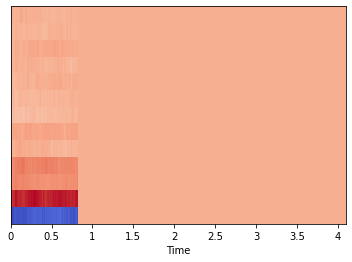

In [7]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / frame수: 400  /  feature수: 13

X_valid :  torch.Size([30, 3, 400, 13]) type: torch.FloatTensor
Y_valid :  torch.Size([30]) type: torch.LongTensor
tensor(0)


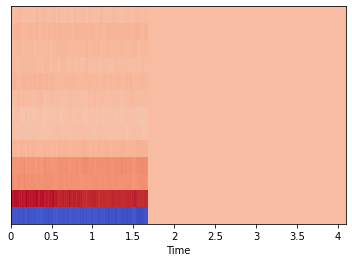

In [8]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / 3채널 / frame수: 400  /  feature수: 13

# RESNET18

In [9]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 400, 13), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 200, 7]           9,408
       BatchNorm2d-2           [-1, 64, 200, 7]             128
              ReLU-3           [-1, 64, 200, 7]               0
         MaxPool2d-4           [-1, 64, 100, 4]               0
            Conv2d-5           [-1, 64, 100, 4]          36,864
       BatchNorm2d-6           [-1, 64, 100, 4]             128
              ReLU-7           [-1, 64, 100, 4]               0
            Conv2d-8           [-1, 64, 100, 4]          36,864
       BatchNorm2d-9           [-1, 64, 100, 4]             128
             ReLU-10           [-1, 64, 100, 4]               0
       BasicBlock-11           [-1, 64, 100, 4]               0
           Conv2d-12           [-1, 64, 100, 4]          36,864
      BatchNorm2d-13           [-1, 64, 100, 4]             128
             ReLU-14           [-1, 64,

In [12]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [13]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [14]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_test_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [22]:
### 10. 학습 및 평가.
# resnet18 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_resnet18_true_noros'+str(data_ind)+'_u.pt'

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)        

[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0248	 Train Acc:53.42 %  | 	Valid Loss:0.0230 	Valid Acc: 63.13 %

Validation loss decreased (inf --> 0.022994).  Saving model ...

[EPOCH:2]	 Train Loss:0.0240	 Train Acc:56.01 %  | 	Valid Loss:0.0224 	Valid Acc: 62.86 %

Validation loss decreased (0.022994 --> 0.022437).  Saving model ...

[EPOCH:3]	 Train Loss:0.0239	 Train Acc:56.88 %  | 	Valid Loss:0.0222 	Valid Acc: 64.72 %

Validation loss decreased (0.022437 --> 0.022168).  Saving model ...

[EPOCH:4]	 Train Loss:0.0237	 Train Acc:57.21 %  | 	Valid Loss:0.0221 	Valid Acc: 65.25 %

Validation loss decreased (0.022168 --> 0.022054).  Saving model ...

[EPOCH:5]	 Train Loss:0.0234	 Train Acc:60.47 %  | 	Valid Loss:0.0221 	Valid Acc: 63.66 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0227	 Train Acc:60.33 %  | 	Valid Loss:0.0221 	Valid Acc: 64.19 %

EarlyStopping counter: 2 out of 5

[EPOCH:7]	 Train Loss:0.0229	 Train Acc:61.53 %  | 	Valid Loss:0.0222 	Valid Acc: 64.


[EPOCH:24]	 Train Loss:0.0182	 Train Acc:71.50 %  | 	Valid Loss:0.0218 	Valid Acc: 67.11 %

EarlyStopping counter: 4 out of 5

[EPOCH:25]	 Train Loss:0.0182	 Train Acc:70.30 %  | 	Valid Loss:0.0198 	Valid Acc: 67.90 %

Validation loss decreased (0.020453 --> 0.019795).  Saving model ...

[EPOCH:26]	 Train Loss:0.0169	 Train Acc:73.95 %  | 	Valid Loss:0.0208 	Valid Acc: 68.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:27]	 Train Loss:0.0195	 Train Acc:69.24 %  | 	Valid Loss:0.0220 	Valid Acc: 62.60 %

EarlyStopping counter: 2 out of 5

[EPOCH:28]	 Train Loss:0.0183	 Train Acc:70.50 %  | 	Valid Loss:0.0215 	Valid Acc: 66.58 %

EarlyStopping counter: 3 out of 5

[EPOCH:29]	 Train Loss:0.0188	 Train Acc:73.42 %  | 	Valid Loss:0.0214 	Valid Acc: 67.64 %

EarlyStopping counter: 4 out of 5

[EPOCH:30]	 Train Loss:0.0170	 Train Acc:75.42 %  | 	Valid Loss:0.0209 	Valid Acc: 65.25 %

EarlyStopping counter: 5 out of 5
[2 교차검증] Early stopping
[3 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0252


[EPOCH:23]	 Train Loss:0.0199	 Train Acc:66.14 %  | 	Valid Loss:0.0211 	Valid Acc: 65.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:24]	 Train Loss:0.0199	 Train Acc:66.60 %  | 	Valid Loss:0.0207 	Valid Acc: 65.69 %

EarlyStopping counter: 2 out of 5

[EPOCH:25]	 Train Loss:0.0190	 Train Acc:69.32 %  | 	Valid Loss:0.0202 	Valid Acc: 67.02 %

EarlyStopping counter: 3 out of 5

[EPOCH:26]	 Train Loss:0.0189	 Train Acc:68.86 %  | 	Valid Loss:0.0218 	Valid Acc: 62.77 %

EarlyStopping counter: 4 out of 5

[EPOCH:27]	 Train Loss:0.0190	 Train Acc:67.93 %  | 	Valid Loss:0.0198 	Valid Acc: 68.35 %

Validation loss decreased (0.020144 --> 0.019807).  Saving model ...

[EPOCH:28]	 Train Loss:0.0184	 Train Acc:70.19 %  | 	Valid Loss:0.0219 	Valid Acc: 60.64 %

EarlyStopping counter: 1 out of 5

[EPOCH:29]	 Train Loss:0.0183	 Train Acc:68.66 %  | 	Valid Loss:0.0196 	Valid Acc: 68.62 %

Validation loss decreased (0.019807 --> 0.019587).  Saving model ...

[EPOCH:30]	 Train Loss:0.0183	 Train Acc

# 모델 결과 확인

In [23]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 77.4751 |	 valid ACC: 67.1088 
[2 교차검증] train ACC : 70.2990 |	 valid ACC: 67.9045 
[3 교차검증] train ACC : 60.1594 |	 valid ACC: 67.5532 
[4 교차검증] train ACC : 61.7530 |	 valid ACC: 65.1596 
[5 교차검증] train ACC : 68.6587 |	 valid ACC: 68.6170 
평균 검증 정확도 67.26860996670241 %


# Model Test

- test set
- confusion matrix

In [24]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [25]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 결과를 모두 합쳐줘야한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))

predictions=[]
answers=[]

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_resnet18_true_noros'+str(data_ind)+'_u.pt'
    model.load_state_dict(torch.load(check_path))
    _,validation_loader = load_data(data_ind-1)

    prediction,answer,test_loss = test_evaluate(model, validation_loader)
    predictions+=[ dat.cpu().numpy() for dat in prediction]
    answers+=[ dat.cpu().numpy() for dat in answer]


    print(confusion_matrix(answers, predictions))

    
cf = confusion_matrix(answers, predictions)
acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
precision=cf[0,0]/(cf[0,0]+cf[1,0])
recall=cf[0,0]/(cf[0,0]+cf[0,1])
#fscore=2*precision*recall/(precision+recall)

fscore = f1_score(answers,predictions,average='macro')

print("Accuracy : {:.4f}% ".format(acc*100))
print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
print("f score : {:.4f} ".format(fscore))


[[188.  51.]
 [ 73.  65.]]
[[391.  87.]
 [158. 118.]]
[[604. 113.]
 [254. 159.]]
[[842. 114.]
 [384. 166.]]
[[1001.  193.]
 [ 423.  265.]]
Accuracy : 67.2689% 
Precision (pathology 예측한 것중 맞는 것) : 0.7029
recall (실제 pathology 중  예측이 맞는 것) : 0.8384
f score : 0.7647 
